In [1]:
!pip install --upgrade PyDOE

Requirement already up-to-date: PyDOE in /usr/local/lib/python3.7/dist-packages (0.3.8)


In [2]:
import jax.numpy as np
import numpy as onp
from jax import vmap, jit, vjp, random
from jax.scipy.linalg import cholesky, solve_triangular
from jax.flatten_util import ravel_pytree
from jax.scipy.stats import norm


from jax.config import config
config.update("jax_enable_x64", True)

from pyDOE import lhs
from functools import partial
from tqdm import trange
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib import rc

# Q1 GP with MLP mean

In [3]:
# A vectorized RBF kernel function - Computes covariance matrix 
def RBF(x1, x2, params):
    output_scale = params[0]
    lengthscales = params[1:]
    diffs = np.expand_dims(x1 / lengthscales, 1) - \
            np.expand_dims(x2 / lengthscales, 0)
    r2 = np.sum(diffs**2, axis=2)
    return output_scale * np.exp(-0.5 * r2)

In [4]:
# A wrapper to call SciPy's L-BFGS-B optimizer - Loss does NOT decompose over datapoints so can't use batches (SGD), instead use quasi Newton method
def minimize_lbfgs(objective, x0, bnds = None):
    result = minimize(objective, x0, jac=True,
                      method='L-BFGS-B', bounds = bnds,
                      callback=None)
    return result.x, result.fun

In [5]:
def MLP(layers):
    def init(rng_key):
        def init_layer(key, d_in, d_out):
            k1, k2 = random.split(key)
            glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
            W = glorot_stddev*random.normal(k1, (d_in, d_out))
            b = np.zeros(d_out)
            return W, b
        key, *keys = random.split(rng_key, len(layers))
        params = list(map(init_layer, keys, layers[:-1], layers[1:]))       #list of tuples containing weights and biases in each layer
        return params
        
    def apply(params, inputs):               #Implements forward pass
        for W, b in params[:-1]:
            outputs = np.dot(inputs, W) + b
            inputs = np.tanh(outputs)
            # Batch normalization here
            # Dropout here
        W, b = params[-1]
        outputs = np.dot(inputs, W) + b      # Last layer is linear transformation for regression (for logistic replace with activation.)
        return outputs
    return init, apply

In [6]:
# A minimal Gaussian process class
class GPRegression:
    # Initialize the class
    def __init__(self, layers, X, kernel_fn = RBF, rng_key = random.PRNGKey(0)): 
        self.kernel = kernel_fn
        self.layers = layers
        dim = X.shape[1]

        # Set up NN initialization and evaluation functions
        self.net_init, self.net_apply = MLP(self.layers)

        rng_key = random.split(rng_key, 2)

        # Initialize the GP and NN parameters
        gp_params = self.random_init_GP(rng_key[0], dim)
        # nn_params = self.net_init(rng_key[1], (-1, self.layers[0]))[1]
        nn_params = self.net_init(rng_key[1])


        # Create indices for retrieving the GP and NN params from the global parameter vector
        nn_params_flat, self.unravel = ravel_pytree(nn_params)
        num_nn_params = len(nn_params_flat)
        num_gp_params = self.random_init_GP(random.PRNGKey(0), self.layers[-1]).shape[0]
        self.gp_params_ids = np.arange(num_gp_params)
        self.nn_params_ids = np.arange(num_nn_params) + num_gp_params


    def random_init_GP(self, rng_key, dim):       #Log ensures positivity
        logsigma_f = np.log(50.0*random.uniform(rng_key, (1,)))
        loglength  = np.log(random.uniform(rng_key, (dim,)) + 1e-8)
        logsigma_n = np.array([-4.0]) + random.normal(rng_key, (1,))
        hyp = np.concatenate([logsigma_f, loglength, logsigma_n])
        return hyp

    def random_init_GP_plus_NN(self, rng_key, dim):       #Log ensures positivity
        logsigma_f = np.log(50.0*random.uniform(rng_key, (1,)))
        loglength  = np.log(random.uniform(rng_key, (dim,)) + 1e-8)
        logsigma_n = np.array([-4.0]) + random.normal(rng_key, (1,))
        hyp = np.concatenate([logsigma_f, loglength, logsigma_n])

        # Initialize NN parameters 
        nn_params = self.net_init(rng_key)
        # nn_params = self.net_init(rng_key, (-1, self.layers[0]))[1]
        hyp = np.concatenate([hyp, ravel_pytree(nn_params)[0]])

        return hyp


    def compute_cholesky(self, params, batch):
        X, _ = batch

        nn_params = self.unravel(params[self.nn_params_ids])
        X = self.net_apply(nn_params, X)

        N, D = X.shape
        # Fetch params
        sigma_n = np.exp(params[-1])
        theta = np.exp(params[:-1])
        # Compute kernel
        K = self.kernel(X, X, theta) + np.eye(N)*(sigma_n + 1e-8)
        L = cholesky(K, lower=True)
        return L

    def likelihood(self, params, batch):
        _, y = batch
        N = y.shape[0]
        # Compute Cholesky
        L = self.compute_cholesky(params, batch)
        # Compute negative log-marginal likelihood
        alpha = solve_triangular(L.T,solve_triangular(L, y, lower=True))
        NLML = 0.5*np.matmul(np.transpose(y),alpha) + \
               np.sum(np.log(np.diag(L))) + 0.5*N*np.log(2.0*np.pi)
        return NLML

    @partial(jit, static_argnums=(0,))
    def likelihood_value_and_grad(self, params, batch):
        fun = lambda params: self.likelihood(params, batch)
        primals, f_vjp = vjp(fun, params)
        grads = f_vjp(np.ones_like(primals))[0]
        return primals, grads

    def train(self, batch, rng_key, num_restarts = 10):
        # Define objective that returns NumPy arrays (to be minimized with SciPy)
        def objective(params):
            value, grads = self.likelihood_value_and_grad(params, batch)
            out = (onp.array(value), onp.array(grads))
            return out
        # Optimize with random restarts
        params = []
        likelihood = []
        X, _ = batch
        dim = X.shape[1]
        rng_key = random.split(rng_key, num_restarts)
        for i in trange(num_restarts):
            init = self.random_init_GP_plus_NN(rng_key[i], dim)
            p, val = minimize_lbfgs(objective, init)
            params.append(p)
            likelihood.append(val)
        params = np.vstack(params)
        likelihood = np.vstack(likelihood)
        #### find the best likelihood (excluding any NaNs) ####
        bestlikelihood = np.nanmin(likelihood)
        idx_best = np.where(likelihood == bestlikelihood)
        idx_best = idx_best[0][0]
        best_params = params[idx_best,:]
        return best_params

    @partial(jit, static_argnums=(0,))
    def predict(self, params, batch, X_star):
        X, y = batch
        # Fetch params
        sigma_n = np.exp(params[-1])
        theta = np.exp(params[:-1])

        nn_params = self.unravel(params[self.nn_params_ids])
        X      = self.net_apply(nn_params, X)
        X_star = self.net_apply(nn_params, X_star)

        # Compute kernels
        k_pp = self.kernel(X_star, X_star, theta) + np.eye(X_star.shape[0])*(sigma_n + 1e-8)
        k_pX = self.kernel(X_star, X, theta)
        L = self.compute_cholesky(params, batch)
        alpha = solve_triangular(L.T,solve_triangular(L, y, lower=True))
        beta  = solve_triangular(L.T,solve_triangular(L, k_pX.T, lower=True))
        # Compute predictive mean, std
        mu = np.matmul(k_pX, alpha)
        cov = k_pp - np.matmul(k_pX, beta)
        std = np.sqrt(np.clip(np.diag(cov), a_min=0.))
        return mu, std

    @partial(jit, static_argnums=(0,))
    def draw_posterior_sample(self, rng_key, params, batch, X_star):
        X, y = batch

        nn_params = self.unravel(params[self.nn_params_ids])
        X      = self.net_apply(nn_params, X)
        X_star = self.net_apply(nn_params, X_star)

        N, D = X.shape
        # Fetch params
        sigma_n = np.exp(params[-1])
        theta = np.exp(params[:-1])

        # Compute kernels
        k_pp = self.kernel(X_star, X_star, theta) + np.eye(X_star.shape[0])*(sigma_n + 1e-8)
        k_pX = self.kernel(X_star, X, theta)
        L = self.compute_cholesky(params, batch)
        alpha = solve_triangular(L.T,solve_triangular(L, y, lower=True))
        beta  = solve_triangular(L.T,solve_triangular(L, k_pX.T, lower=True))
        # Compute predictive mean
        mu = np.matmul(k_pX, alpha)
        cov = k_pp - np.matmul(k_pX, beta)
        sample = random.multivariate_normal(rng_key, mu, cov)
        return sample    

In [7]:
def f_step(x):
  y = np.heaviside(x, 1)
  return y[0]  

## Noise free data

In [8]:
N = 50
dim = 1
noise = 0.0
lb = np.array([-1.0])
ub = np.array([1.0])

# Training data
X = lb + (ub-lb)*lhs(dim, N)

y = vmap(f_step)(X)
y = y + noise*y.std(0)*onp.random.randn(N,)

# Test data
n_star = 1000
X_star = np.linspace(lb[0], ub[0], n_star)[:,None]
y_star = vmap(f_step)(X_star)

In [9]:
layers = [dim, 2, 1]
model = GPRegression(layers, X, kernel_fn = RBF)

In [10]:
# Normalize training data
mu_y, sigma_y = y.mean(0), y.std(0)
X_train = (X - lb)/(ub-lb)
y_train = (y - mu_y)/sigma_y

# Train model
train_key = random.PRNGKey(0)
opt_params = model.train((X_train, y_train), train_key, num_restarts = 10)

100%|██████████| 10/10 [00:05<00:00,  1.87it/s]


In [11]:
# Normalize test inputs
X_test = (X_star - lb)/(ub-lb)

# Make predictions
mean, std = model.predict(opt_params, (X_train, y_train), X_test)

# De-normalize predictions
mean, std = mean*sigma_y + mu_y, std*sigma_y

# Uncertainty bands
lower = mean - 2.0*std
upper = mean + 2.0*std

# Draw posterior samples
num_draws = 10
test_keys = random.split(random.PRNGKey(0), num_draws)
sample_fn = lambda key: model.draw_posterior_sample(key, opt_params, (X_train, y_train), X_test)
f_samples = vmap(sample_fn)(test_keys)
f_samples = f_samples*sigma_y + mu_y

# Check accuracy
error = np.linalg.norm(mean-y_star,2)/np.linalg.norm(y_star,2)
print("Relative L2 error u: %e" % (error))

Relative L2 error u: 1.015797e-01


Text(0, 0.5, '$f(x)$')

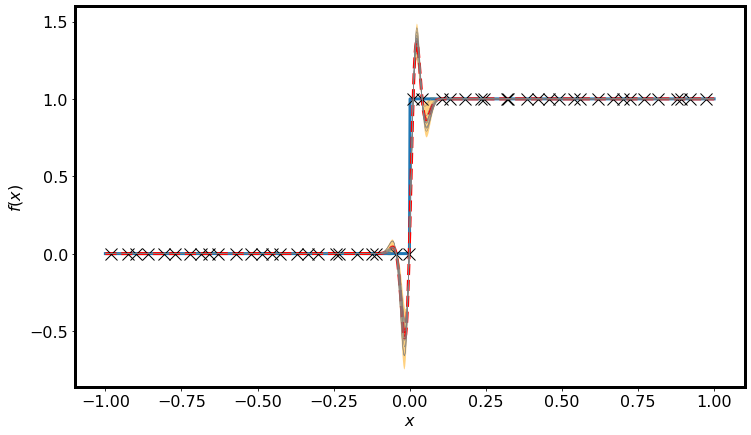

In [12]:
# Plot
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.linewidth']=3

plt.figure(figsize = (12,7))
plt.plot(X_star, y_star, lw = 3)
plt.plot(X_star, mean, 'r--', lw = 3)
plt.plot(X, y, 'kx', ms = 12)
plt.fill_between(X_star.flatten(), lower.flatten(), upper.flatten(), 
                  facecolor='orange', alpha=0.5, label="Two std band")
for i in range(num_draws):
    plt.plot(X_star, f_samples[i,:], '-', color='gray', lw = 0.5)
plt.xlabel(r'$x$')
plt.ylabel(r'$f(x)$')

## Noisy data

In [13]:

# Training data
noise = 0.01
X = lb + (ub-lb)*lhs(dim, N)

y = vmap(f_step)(X)
y = y + noise*y.std(0)*onp.random.normal(size = (N,))

# Test data
n_star = 1000
X_star = np.linspace(lb[0], ub[0], n_star)[:,None]
y_star = vmap(f_step)(X_star)

In [14]:
layers = [dim, 2, 1]
model = GPRegression(layers, X, kernel_fn = RBF)

In [15]:
# Normalize training data
mu_y, sigma_y = y.mean(0), y.std(0)
X_train = (X - lb)/(ub-lb)
y_train = (y - mu_y)/sigma_y

# Train model
train_key = random.PRNGKey(0)
opt_params = model.train((X_train, y_train), train_key, num_restarts = 10)

100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


In [16]:
# Normalize test inputs
X_test = (X_star - lb)/(ub-lb)

# Make predictions
mean, std = model.predict(opt_params, (X_train, y_train), X_test)

# De-normalize predictions
mean, std = mean*sigma_y + mu_y, std*sigma_y

# Uncertainty bands
lower = mean - 2.0*std
upper = mean + 2.0*std

# Draw posterior samples
num_draws = 10
test_keys = random.split(random.PRNGKey(0), num_draws)
sample_fn = lambda key: model.draw_posterior_sample(key, opt_params, (X_train, y_train), X_test)
f_samples = vmap(sample_fn)(test_keys)
f_samples = f_samples*sigma_y + mu_y

# Check accuracy
error = np.linalg.norm(mean-y_star,2)/np.linalg.norm(y_star,2)
print("Relative L2 error u: %e" % (error))

Relative L2 error u: 6.323899e-02


Text(0, 0.5, '$f(x)$')

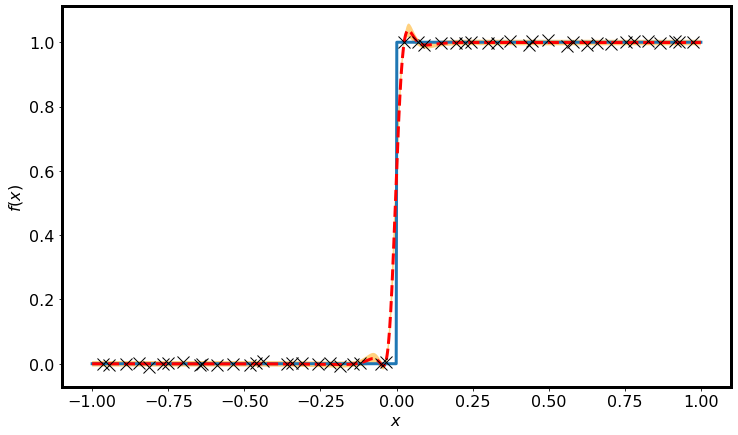

In [17]:
# Plot
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.linewidth']=3

plt.figure(figsize = (12,7))
plt.plot(X_star, y_star, lw = 3)
plt.plot(X_star, mean, 'r--', lw = 3)
plt.plot(X, y, 'kx', ms = 12)
plt.fill_between(X_star.flatten(), lower.flatten(), upper.flatten(), 
                  facecolor='orange', alpha=0.5, label="Two std band")
# for i in range(num_draws):
#     plt.plot(X_star, f_samples[i,:], '-', color='gray', lw = 0.5)
plt.xlabel(r'$x$')
plt.ylabel(r'$f(x)$')

# Q2 Multi-Fidelity

In [18]:
# A minimal Gaussian process class
class GPRegression:
    # Initialize the class
    def __init__(self, kernel_fn = RBF): 
        self.kernel = kernel_fn
                              
    def random_init_GP(self, rng_key, dimL, dimH):       #Log ensures positivity
        logsigma_f_L = np.log(50.0*random.uniform(rng_key, (1,)))
        loglength_L  = np.log(random.uniform(rng_key, (dimL,)) + 1e-8)
        logsigma_n_L = np.array([-4.0]) + random.normal(rng_key, (1,))

        logsigma_f_H = np.log(50.0*random.uniform(rng_key, (1,)))
        loglength_H  = np.log(random.uniform(rng_key, (dimH,)) + 1e-8)
        logsigma_n_H = np.array([-4.0]) + random.normal(rng_key, (1,))

        logrho = random.normal(rng_key, (1,))

        hyp = np.concatenate([logsigma_f_L, loglength_L, logsigma_n_L, logsigma_f_H, loglength_H, logsigma_n_H, logrho])
        return hyp

    def compute_cholesky(self, params, batch):
        XL, _, XH, _ = batch
        NL, DL = XL.shape
        NH, DH = XH.shape

        # Fetch params
        sigma_n_L = np.exp(params[DL+1])
        theta_L = np.exp(params[:DL+1]) 
        sigma_n_H = np.exp(params[DL+DH+3])
        theta_H = np.exp(params[DL+2:DL+DH+3])
        rho = params[-1]

        # Compute kernels

        kLL = self.kernel(XL, XL, theta_L) + np.eye(NL)*(sigma_n_L + 1e-8)
        kLH = rho * self.kernel(XL, XH, theta_L)
        kHH = (rho**2.0) * self.kernel(XH, XH, theta_L) + self.kernel(XH, XH, theta_H) + np.eye(NH)*(sigma_n_H + 1e-8)        

        K1 = np.hstack([kLL  , kLH])
        K2 = np.hstack([kLH.T, kHH])

        # Construct final kernel        
        K = np.vstack([K1, K2])
        L = cholesky(K, lower=True)
        return L

    def likelihood(self, params, batch):
        _, yL, _, yH = batch
        NL = yL.shape[0]
        NH = yH.shape[0]
        y  = np.concatenate([yL, yH])

        # Compute Cholesky
        L = self.compute_cholesky(params, batch)
        alpha = solve_triangular(L.T,solve_triangular(L, y, lower=True))

        # Compute negative log-marginal likelihood
        NLML = 0.5*np.matmul(np.transpose(y),alpha) + 0.5*np.sum(np.log(np.diag(L))) + 0.5*(NL+NH)*np.log(2.0*np.pi)

        return NLML

    @partial(jit, static_argnums=(0,))
    def likelihood_value_and_grad(self, params, batch):
        fun = lambda params: self.likelihood(params, batch)
        primals, f_vjp = vjp(fun, params)
        grads = f_vjp(np.ones_like(primals))[0]
        return primals, grads

    def train(self, batch, rng_key, num_restarts = 10):
        # Define objective that returns NumPy arrays (to be minimized with SciPy)
        def objective(params):
            value, grads = self.likelihood_value_and_grad(params, batch)
            out = (onp.array(value), onp.array(grads))
            return out
        # Optimize with random restarts
        params = []
        likelihood = []
        XL, _, XH, _ = batch
        dimL = XL.shape[1]
        dimH = XH.shape[1]        
        rng_key = random.split(rng_key, num_restarts)
        for i in trange(num_restarts):
            init = self.random_init_GP(rng_key[i], dimL, dimH)
            p, val = minimize_lbfgs(objective, init)
            params.append(p)
            likelihood.append(val)
        params = np.vstack(params)
        likelihood = np.vstack(likelihood)
        #### find the best likelihood (excluding any NaNs) ####
        bestlikelihood = np.nanmin(likelihood)
        idx_best = np.where(likelihood == bestlikelihood)
        idx_best = idx_best[0][0]
        best_params = params[idx_best,:]
        return best_params

    @partial(jit, static_argnums=(0,))
    def predict(self, params, batch, X_star):
        XL, yL, XH, yH,  = batch
        NL, DL = XL.shape
        NH, DH = XH.shape
        Nstar = X_star.shape[0]

        # Fetch params
        sigma_n_L = np.exp(params[DL+1])
        theta_L = np.exp(params[:DL+1])
        sigma_n_H = np.exp(params[DL+DH+3])
        theta_H = np.exp(params[DL+2:DL+DH+3])
        rho = params[-1]

        # Compute kernels
        kLL = self.kernel(XL, XL, theta_L) + np.eye(NL)*(sigma_n_L + 1e-8)
        kLH = rho * self.kernel(XL, XH, theta_L)
        kHH = (rho**2.0) * self.kernel(XH, XH, theta_L) + self.kernel(XH, XH, theta_H) + np.eye(NH)*(sigma_n_H + 1e-8)        

        kLHpX1 = rho * self.kernel(X_star, XL, theta_L)
        kHHpp = (rho**2.0) * self.kernel(X_star, X_star, theta_L) + self.kernel(X_star, X_star, theta_H) + np.eye(Nstar)*(sigma_n_H + 1e-8)
        kHHpX = (rho**2.0) * self.kernel(X_star, XH, theta_L)     + self.kernel(X_star, XH, theta_H)     + np.eye(Nstar,NH)*(sigma_n_H + 1e-8)

        kLLpp = self.kernel(X_star, X_star, theta_L) + np.eye(Nstar)*(sigma_n_L + 1e-8)
        kLLpX = self.kernel(X_star, XL, theta_L) + np.eye(Nstar,NL)*(sigma_n_L + 1e-8)
        kLHpX2 = rho * self.kernel(X_star, XH, theta_L)

        K1 = np.hstack((kLL  , kLH))
        K2 = np.hstack((kLH.T, kHH))

        # Construct final kernel        
        K = np.vstack((K1, K2))

        k_pX_H = np.hstack((kLHpX1, kHHpX))
        k_pp_H = kHHpp

        k_pX_L = np.hstack((kLLpX, kLHpX2))
        k_pp_L = kLLpp

        L = self.compute_cholesky(params, batch)

        alpha_H = solve_triangular(L.T,solve_triangular(L, y, lower=True))
        beta_H  = solve_triangular(L.T,solve_triangular(L, k_pX_H.T, lower=True))

        alpha_L = solve_triangular(L.T,solve_triangular(L, y, lower=True))
        beta_L  = solve_triangular(L.T,solve_triangular(L, k_pX_L.T, lower=True))


        # Compute predictive mean
        mu_H = np.matmul(k_pX_H, alpha_H)
        cov_H = k_pp_H - np.matmul(k_pX_H, beta_H)
        std_H = np.sqrt(np.clip(np.diag(cov_H), a_min=0.))

        mu_L = np.matmul(k_pX_L, alpha_L)
        cov_L = k_pp_L - np.matmul(k_pX_L, beta_L)
        std_L = np.sqrt(np.clip(np.diag(cov_L), a_min=0.))

        return mu_H, std_H, mu_L, std_L

    @partial(jit, static_argnums=(0,))
    def draw_posterior_sample(self, rng_key, params, batch, X_star):
        XL, yL, XH, yH,  = batch
        NL, DL = XL.shape
        NH, DH = XH.shape
        Nstar = X_star.shape[0]

        # Fetch params
        sigma_n_L = np.exp(params[DL+1])
        theta_L = np.exp(params[:DL+1])
        sigma_n_H = np.exp(params[DL+DH+3])
        theta_H = np.exp(params[DL+2:DL+DH+3])
        rho = params[-1]

        # Compute kernels
        kLL = self.kernel(XL, XL, theta_L) + np.eye(NL)*(sigma_n_L + 1e-8)
        kLH = rho * self.kernel(XL, XH, theta_L)
        kHH = (rho**2.0) * self.kernel(XH, XH, theta_L) + self.kernel(XH, XH, theta_H) + np.eye(NH)*(sigma_n_H + 1e-8)        

        kLHpX1 = rho * self.kernel(X_star, XL, theta_L)
        kHHpp = (rho**2.0) * self.kernel(X_star, X_star, theta_L) + self.kernel(X_star, X_star, theta_H) + np.eye(Nstar)*(sigma_n_H + 1e-8)
        kHHpX = (rho**2.0) * self.kernel(X_star, XH, theta_L)     + self.kernel(X_star, XH, theta_H)     + np.eye(Nstar,NH)*(sigma_n_H + 1e-8)

        kLLpp = self.kernel(X_star, X_star, theta_L) + np.eye(Nstar)*(sigma_n_L + 1e-8)
        kLLpX = self.kernel(X_star, XL, theta_L) + np.eye(Nstar,NL)*(sigma_n_L + 1e-8)
        kLHpX2 = rho * self.kernel(X_star, XH, theta_L)

        K1 = np.hstack((kLL  , kLH))
        K2 = np.hstack((kLH.T, kHH))

        # Construct final kernel        
        K = np.vstack((K1, K2))

        k_pX_H = np.hstack((kLHpX1, kHHpX))
        k_pp_H = kHHpp

        k_pX_L = np.hstack((kLLpX, kLHpX2))
        k_pp_L = kLLpp

        L = self.compute_cholesky(params, batch)
        alpha = solve_triangular(L.T,solve_triangular(L, y, lower=True))
        beta  = solve_triangular(L.T,solve_triangular(L, k_pX_H.T, lower=True))

        # Compute predictive mean
        mu_H = np.matmul(k_pX_H, alpha)
        cov_H = k_pp_H - np.matmul(k_pX_H, beta)
        sample = random.multivariate_normal(rng_key, mu_H, cov_H)
        return sample    

In [19]:
def fH(x):
  y = (6*x - 2.0)**2.0 * np.sin(12.0*x - 4.0)
  return y[0]

def fL(x):
  y = 0.5*fH(x) + 10*(x-0.5) - 5.0
  return y[0] 

In [20]:
for nL in [3, 5, 7, 9, 11, 13]:
    nH = 4
    dim = 1
    noise = 0.0
    lb = np.array([0.0])
    ub = np.array([1.0])

    # Training data
    XL = np.linspace(lb[0], ub[0], nL)[:,None]
    yL = vmap(fL)(XL)
    yL = yL + noise*yL.std(0)*onp.random.randn(nL,)

    # XH = np.array([0.0,0.4,0.6,1.0])[:,None]
    XH = np.linspace(lb[0], ub[0], nH)[:,None]
    yH = vmap(fH)(XH)

    X = np.concatenate([XL, XH])
    y = np.concatenate([yL, yH])

    # Test data
    n_star = 1000
    X_star = np.linspace(lb[0], ub[0], n_star)[:,None]
    y_star_H = vmap(fH)(X_star)
    y_star_L = vmap(fL)(X_star)

    model = GPRegression(kernel_fn = RBF)

    # Normalize training data
    mu_y, sigma_y = y.mean(0), y.std(0)
    XL_train = (XL - lb)/(ub-lb)
    yL_train = (yL - mu_y)/sigma_y
    XH_train = (XH - lb)/(ub-lb)
    yH_train = (yH - mu_y)/sigma_y

    # Train model
    train_key = random.PRNGKey(0)
    opt_params = model.train((XL_train, yL_train, XH_train, yH_train), train_key, num_restarts = 20)

    # Normalize test inputs
    X_test = (X_star - lb)/(ub-lb)

    # Make predictions
    mean_H, std_H, mean_L, std_L = model.predict(opt_params, (XL_train, yL_train, XH_train, yH_train), X_test)


    lower = mean_L - 2.0*std_L
    upper = mean_L + 2.0*std_L


    # Check accuracy
    error = np.linalg.norm(mean_L-y_star_L,2)/np.linalg.norm(y_star_L,2)
    print('nL: ', nL, ' Relative L2 error: ', error)

100%|██████████| 20/20 [00:01<00:00, 10.64it/s]


nL:  3  Relative L2 error:  0.5459068115262143


100%|██████████| 20/20 [00:02<00:00,  9.72it/s]


nL:  5  Relative L2 error:  0.1859715529885608


100%|██████████| 20/20 [00:03<00:00,  6.42it/s]


nL:  7  Relative L2 error:  0.1059763791971178


100%|██████████| 20/20 [00:02<00:00,  8.64it/s]


nL:  9  Relative L2 error:  0.016214698629517594


100%|██████████| 20/20 [00:02<00:00,  7.91it/s]


nL:  11  Relative L2 error:  0.004301103531746106


100%|██████████| 20/20 [00:03<00:00,  5.75it/s]


nL:  13  Relative L2 error:  0.0002134416463805392


# Q3 Active Learning

In [21]:
# A minimal Gaussian process class
class GPRegression:
    # Initialize the class
    def __init__(self, kernel_fn = RBF, acq_fn = None): 
        self.kernel = kernel_fn
        self.acq_fn = acq_fn
                              
    def random_init_GP(self, rng_key, dim):
        logsigma_f = np.log(50.0*random.uniform(rng_key, (1,)))
        loglength  = np.log(random.uniform(rng_key, (dim,)) + 1e-8)
        logsigma_n = np.array([-4.0]) + random.normal(rng_key, (1,))
        hyp = np.concatenate([logsigma_f, loglength, logsigma_n])
        return hyp

    def compute_cholesky(self, params, batch):
        X, _ = batch
        N, D = X.shape
        # Fetch params
        sigma_n = np.exp(params[-1])
        theta = np.exp(params[:-1])
        # Compute kernel
        K = self.kernel(X, X, theta) + np.eye(N)*(sigma_n + 1e-8)
        L = cholesky(K, lower=True)
        return L

    def likelihood(self, params, batch):
        _, y = batch
        N = y.shape[0]
        # Compute Cholesky
        L = self.compute_cholesky(params, batch)
        # Compute negative log-marginal likelihood
        alpha = solve_triangular(L.T,solve_triangular(L, y, lower=True))
        NLML = 0.5*np.matmul(np.transpose(y),alpha) + \
               np.sum(np.log(np.diag(L))) + 0.5*N*np.log(2.0*np.pi)
        return NLML

    @partial(jit, static_argnums=(0,))
    def likelihood_value_and_grad(self, params, batch):
        fun = lambda params: self.likelihood(params, batch)
        primals, f_vjp = vjp(fun, params)
        grads = f_vjp(np.ones_like(primals))[0]
        return primals, grads

    def train(self, batch, rng_key, num_restarts = 10):
        # Define objective that returns NumPy arrays (to be minimized with SciPy)
        def objective(params):
            value, grads = self.likelihood_value_and_grad(params, batch)
            out = (onp.array(value), onp.array(grads))
            return out
        # Optimize with random restarts
        params = []
        likelihood = []
        X, _ = batch
        dim = X.shape[1]
        rng_key = random.split(rng_key, num_restarts)
        for i in range(num_restarts):
            init = self.random_init_GP(rng_key[i], dim)
            p, val = minimize_lbfgs(objective, init)
            params.append(p)
            likelihood.append(val)
        params = np.vstack(params)
        likelihood = np.vstack(likelihood)
        #### find the best likelihood (excluding any NaNs) ####
        bestlikelihood = np.nanmin(likelihood)
        idx_best = np.where(likelihood == bestlikelihood)
        idx_best = idx_best[0][0]
        best_params = params[idx_best,:]
        return best_params

    @partial(jit, static_argnums=(0,))
    def predict(self, params, batch, X_star):
        X, y = batch
        # Fetch params
        sigma_n = np.exp(params[-1])
        theta = np.exp(params[:-1])
        # Compute kernels
        k_pp = self.kernel(X_star, X_star, theta) + np.eye(X_star.shape[0])*(sigma_n + 1e-8)
        k_pX = self.kernel(X_star, X, theta)
        L = self.compute_cholesky(params, batch)
        alpha = solve_triangular(L.T,solve_triangular(L, y, lower=True))
        beta  = solve_triangular(L.T,solve_triangular(L, k_pX.T, lower=True))
        # Compute predictive mean, std
        mu = np.matmul(k_pX, alpha)
        cov = k_pp - np.matmul(k_pX, beta)
        std = np.sqrt(np.clip(np.diag(cov), a_min=0.))
        return mu, std

    @partial(jit, static_argnums=(0,))
    def draw_posterior_sample(self, rng_key, params, batch, X_star):
        X, y = batch
        N, D = X.shape
        # Fetch params
        sigma_n = np.exp(params[-1])
        theta = np.exp(params[:-1])
        # Compute kernels
        k_pp = self.kernel(X_star, X_star, theta) + np.eye(X_star.shape[0])*(sigma_n + 1e-8)
        k_pX = self.kernel(X_star, X, theta)
        L = self.compute_cholesky(params, batch)
        alpha = solve_triangular(L.T,solve_triangular(L, y, lower=True))
        beta  = solve_triangular(L.T,solve_triangular(L, k_pX.T, lower=True))
        # Compute predictive mean
        mu = np.matmul(k_pX, alpha)
        cov = k_pp - np.matmul(k_pX, beta)
        sample = random.multivariate_normal(rng_key, mu, cov)
        return sample    

    def acquisition(self, params, batch, x):
        x = x[None,:]
        _, y = batch
        mean, std = self.predict(params, batch, x)
        if self.acq_fn == 'UCB':
            return -(mean[0] + 2 * std[0])
        elif self.acq_fn == 'PI':
            best = np.min(y)
            Z    = (best - mean) / std
            return -norm.cdf(Z)
        elif self.acq_fn == 'EI':
            best = np.min(y)
            Z    = (best - mean) / std
            return -((best - mean) * norm.cdf(Z) + std * norm.pdf(Z))
        elif self.acq_fn == 'US':
            return -std[0]
        elif self.acq_fn == 'LCB':
            return (mean[0] - 2 * std[0])
        else:
            raise NotImplementedError

    @partial(jit, static_argnums=(0,))
    def acq_value_and_grad(self, params, batch, x):
        fun = lambda x: self.acquisition(params, batch, x)
        primals, f_vjp = vjp(fun, x)
        grads = f_vjp(np.ones_like(primals))[0]
        return primals, grads

    def next_best_point(self, params, batch, bounds, rng_key, num_restarts = 10):
        # Define objective that returns NumPy arrays
        def objective(x):
            x = (x - lb)/(ub-lb)
            value, grads = self.acq_value_and_grad(params, batch, x)
            out = (onp.array(value), onp.array(grads))
            return out
        # Optimize with random restarts
        loc = []
        acq = []
        lb, ub = bounds
        dim = lb.shape[0]
        onp.random.seed(rng_key[0])
        x0 = lb + (ub-lb)*lhs(dim, num_restarts)
        dom_bounds = tuple(map(tuple, np.vstack((lb, ub)).T))
        for i in range(num_restarts):
            pos, val = minimize_lbfgs(objective, x0[i,:], bnds = dom_bounds)
            loc.append(pos)
            acq.append(val)
        loc = np.vstack(loc)
        acq = np.vstack(acq)
        idx_best = np.argmin(acq)
        x_new = loc[idx_best:idx_best+1,:]
        return x_new

In [22]:
def branin():
    dim = 2
    lb = np.array([-5.0, 0.0])
    ub = np.array([10.0, 15.0])
    def f(x):
        a = 1.0
        b = 5.1 / (4*np.pi**2)
        c = 5 / np.pi
        r = 6
        s = 10
        t = 1 / (8*np.pi)
        x1, x2 = x[0], x[1]
        y = a * (x2 - b*x1**2 + c*x1 -r)**2 + s * (1-t) * np.cos(x1) + s
        return y
    return f, dim, (lb, ub)

In [23]:
# Define test function
f, dim, bounds = branin()

# Problem settings
N = 10
noise = 0.0
lb, ub = bounds

# Initial training data
X = lb + (ub-lb)*lhs(dim, N)
y = vmap(f)(X)
y = y + noise*y.std(0)*onp.random.randn(N,)

# Test data
nn = 80
xx = np.linspace(lb[0], ub[0], nn)
yy = np.linspace(lb[1], ub[1], nn)
XX, YY = np.meshgrid(xx, yy)
X_star = np.concatenate([XX.flatten()[:,None], 
                          YY.flatten()[:,None]], axis = 1)
y_star = vmap(f)(X_star)

# Normalized test inputs
X_test = (X_star - lb)/(ub-lb)

In [24]:
model1 = GPRegression(kernel_fn = RBF, acq_fn = 'PI')
model2 = GPRegression(kernel_fn = RBF, acq_fn = 'EI')
model3 = GPRegression(kernel_fn = RBF, acq_fn = 'UCB')
model4 = GPRegression(kernel_fn = RBF, acq_fn = 'LCB')

In [25]:
# Initializing x and y for all the models:
X1 = X2 = X3 = X4 = X; y1 = y2 = y3 = y4 = y
# Number of iterations in active learning loop
num_iter   = 20


y1_mins = []
y2_mins = []
y3_mins = []
y4_mins = []

for it in trange(num_iter):
    # Normalize training data
    mu_y1, sigma_y1 = y1.mean(0), y1.std(0)
    X1_train       = (X1 - lb)/(ub-lb)
    y1_train       = (y1 - mu_y1)/sigma_y1

    mu_y2, sigma_y2 = y2.mean(0), y2.std(0)
    X2_train       = (X2 - lb)/(ub-lb)
    y2_train       = (y2 - mu_y2)/sigma_y2

    mu_y3, sigma_y3 = y3.mean(0), y3.std(0)
    X3_train       = (X3 - lb)/(ub-lb)
    y3_train       = (y3 - mu_y3)/sigma_y3

    mu_y4, sigma_y4 = y4.mean(0), y4.std(0)
    X4_train       = (X4 - lb)/(ub-lb)
    y4_train       = (y4 - mu_y4)/sigma_y4

    # Train model
    train_key = random.PRNGKey(it)
    opt_params1 = model1.train((X1_train, y1_train), train_key, num_restarts = 50)
    opt_params2 = model2.train((X2_train, y2_train), train_key, num_restarts = 50)
    opt_params3 = model3.train((X3_train, y3_train), train_key, num_restarts = 50)
    opt_params4 = model4.train((X4_train, y4_train), train_key, num_restarts = 50)

    # Select next best point
    new_X1 = model1.next_best_point(opt_params1, 
                                    (X1_train, y1_train), bounds, train_key, 
                                    num_restarts = 50
                                   )
    new_X2 = model2.next_best_point(opt_params2, 
                                    (X2_train, y2_train), bounds, train_key, 
                                    num_restarts = 50
                                   )
    new_X3 = model3.next_best_point(opt_params3, 
                                    (X3_train, y3_train), bounds, train_key, 
                                    num_restarts = 50
                                   )
    new_X4 = model4.next_best_point(opt_params4, 
                                    (X4_train, y4_train), bounds, train_key, 
                                    num_restarts = 50
                                   )

    # Acquire data
    new_y1 = vmap(f)(new_X1)
    new_y2 = vmap(f)(new_X2)
    new_y3 = vmap(f)(new_X3)
    new_y4 = vmap(f)(new_X4)

    # Augment training data
    X1 = np.concatenate([X1, new_X1], axis = 0)
    y1 = np.concatenate([y1, new_y1], axis = 0)
    X2 = np.concatenate([X2, new_X2], axis = 0)
    y2 = np.concatenate([y2, new_y2], axis = 0)
    X3 = np.concatenate([X3, new_X3], axis = 0)
    y3 = np.concatenate([y3, new_y3], axis = 0)
    X4 = np.concatenate([X4, new_X4], axis = 0)
    y4 = np.concatenate([y4, new_y4], axis = 0)

    # Monitor prediction error
    mean1, std1 = model1.predict(opt_params1, (X1_train, y1_train), X_test)
    mean2, std2 = model2.predict(opt_params2, (X2_train, y2_train), X_test)
    mean3, std3 = model3.predict(opt_params3, (X3_train, y3_train), X_test)
    mean4, std4 = model4.predict(opt_params4, (X4_train, y4_train), X_test)
    
    mean1, std1 = mean1 * sigma_y1 + mu_y1, std1 * sigma_y1
    mean2, std2 = mean2 * sigma_y2 + mu_y2, std2 * sigma_y2 
    mean3, std3 = mean3 * sigma_y3 + mu_y3, std3 * sigma_y3 
    mean4, std4 = mean4 * sigma_y4 + mu_y4, std4 * sigma_y4 
    
    y1_mins.append(y1.min().copy())
    y2_mins.append(y2.min().copy())
    y3_mins.append(y3.min().copy())
    y4_mins.append(y4.min().copy())

100%|██████████| 20/20 [05:58<00:00, 17.94s/it]


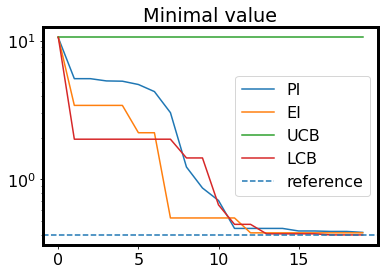

In [27]:
plt.figure(figsize = (6,4))
plt.plot(np.array(y1_mins), label = 'PI')
plt.plot(np.array(y2_mins), label = 'EI')
plt.plot(np.array(y3_mins), label = 'UCB')
plt.plot(np.array(y4_mins), label = 'LCB')
plt.yscale('log')
plt.axhline(0.397887,linestyle = '--', label = 'reference')
plt.title('Minimal value')
plt.legend()
plt.show()
plt.close()